In [39]:
from pymed import PubMed
from concurrent.futures import ThreadPoolExecutor
import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


pubmed = PubMed(tool="MyTool", email="b.mascat@gmail.com")
farmacos = pd.read_csv("farmacos.csv", header=None, names=['Farmaco'])
tumores = pd.read_csv("tipo_tumores.csv", header=None, names=['TipoTumor'])

# Función para obtener el número de resultados
def get_results_count(query):
    return pubmed.getTotalResultsCount(query)

# Función para procesar una única combinación de tipos de tumor y fármacos
def process_combination(tipo_tumor, farmaco):
    query = f"{tipo_tumor} AND {farmaco}"
    results_count = get_results_count(query)
    return {'TipoTumor': tipo_tumor, 'Farmaco': farmaco, 'Resultados': results_count}


In [20]:
# Inicializar una lista para almacenar los resultados
results_list = []

# Bucle anidado para combinar tipos de tumor y fármacos
for tipo_tumor in tumores['TipoTumor']:
    for farmaco in farmacos['Farmaco']:
        # Crear la consulta combinando el tipo de tumor y el fármaco
        query = f"{tipo_tumor} AND {farmaco}"
        # Obtener el número de resultados
        results_count = get_results_count(query)
        # Agregar los resultados a la lista
        results_list.append({'TipoTumor': tipo_tumor, 'Farmaco': farmaco, 'Resultados': results_count})

# Crear un DataFrame a partir de la lista de resultados
results_df = pd.DataFrame(results_list)

# Mostrar el DataFrame final
print("DataFrame de Resultados:")
print(results_df)

DataFrame de Resultados:
                          TipoTumor                Farmaco  Resultados
0            Gastric Adenocarcinoma          PEMBROlizumab         129
1            Gastric Adenocarcinoma            OSIMERTINIB           4
2            Gastric Adenocarcinoma              NIVOlumab         133
3            Gastric Adenocarcinoma            ABEMACICLIB           0
4            Gastric Adenocarcinoma  EMTANSINA TRASTUZUMAB           0
...                             ...                    ...         ...
2595  Colorectal Carcinoma Invasive              RUCAPARIB           0
2596  Colorectal Carcinoma Invasive               ALBÚMINA           0
2597  Colorectal Carcinoma Invasive           TEMOZOLOMIDA           4
2598  Colorectal Carcinoma Invasive           OXALIPLATINO         355
2599  Colorectal Carcinoma Invasive              SOTORASIB           2

[2600 rows x 3 columns]


In [21]:
#Salvar resultados de la búsqueda en pubmed en .csv
results_df.to_csv('resultados_pubmed.csv', index=False)

In [40]:
# Crear una lista de combinaciones de tipos de tumor y fármacos
combinations = [(tipo_tumor, farmaco) for tipo_tumor in tumores['TipoTumor'] for farmaco in farmacos['Farmaco']]

# Utilizar ThreadPoolExecutor para procesar las combinaciones en paralelo
with ThreadPoolExecutor() as executor:
    for combination in combinations:
        results_list.append(executor.submit(lambda x: process_combination(*x), combination).result())
        time.sleep(1)  # Esperar 1 segundo entre cada solicitud


# Crear un DataFrame a partir de la lista de resultados
results_df = pd.DataFrame(results_list)

# Mostrar el DataFrame final
print("DataFrame de Resultados:")
print(results_df)

KeyboardInterrupt: 

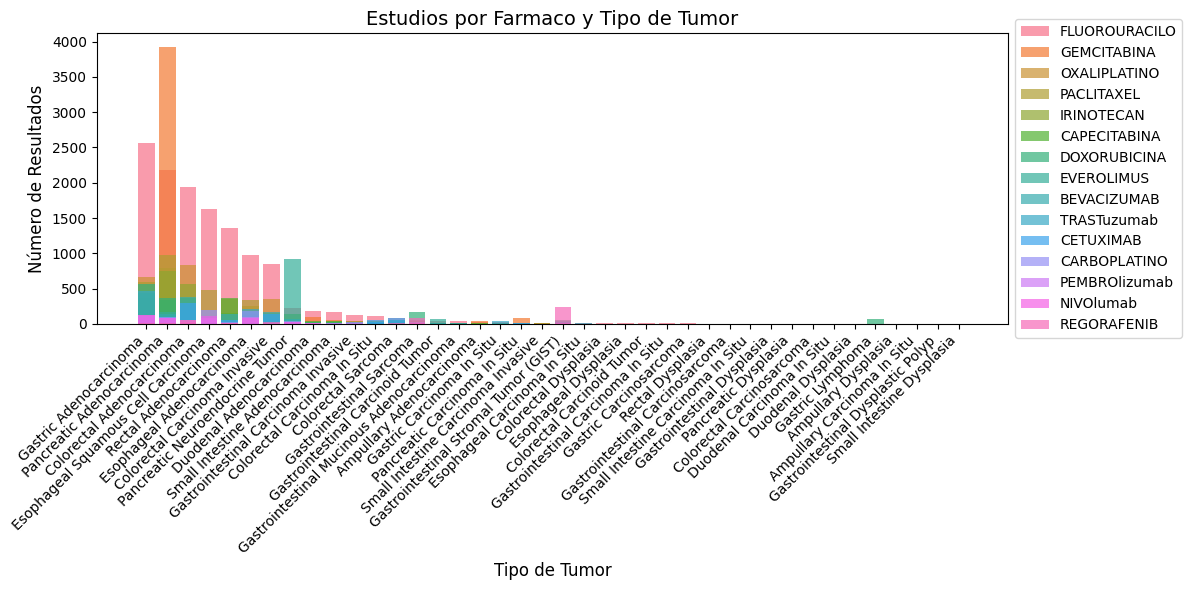

In [36]:
#Visualizar los resultados de cada farmaco en función del tipo de cancer

import matplotlib.pyplot as plt

# Agrupar y sumar los resultados por farmaco y tipo de tumor
grouped_results = results_df.groupby(['Farmaco', 'TipoTumor']).sum().reset_index()

# Filtrar para mostrar solo los 15 fármacos más utilizados
top_farmacos = grouped_results.groupby('Farmaco')['Resultados'].sum().nlargest(15).index
grouped_results = grouped_results[grouped_results['Farmaco'].isin(top_farmacos)]

# Ordenar el DataFrame por el número de resultados de mayor a menor
grouped_results = grouped_results.sort_values(by='Resultados', ascending=False)

# Obtener una paleta de colores única para cada fármaco
colores = sns.color_palette('husl', n_colors=len(top_farmacos))

# Crear el diagrama de barras
plt.figure(figsize=(12, 6))  # Ajustar el tamaño del gráfico

for i, farmaco in enumerate(top_farmacos):
    subset = grouped_results[grouped_results['Farmaco'] == farmaco]
    plt.bar(subset['TipoTumor'], subset['Resultados'], label=farmaco, alpha=0.7, color=colores[i])

plt.xlabel('Tipo de Tumor', fontsize=12)
plt.ylabel('Número de Resultados', fontsize=12)
plt.title('Estudios por Farmaco y Tipo de Tumor', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))  # Colocar la leyenda a la derecha
plt.tight_layout()  # Ajustar el diseño del gráfico
plt.show()
